## Imports

In [8]:
import pymc3 as pm
import numpy as np
import pandas as pd
import arviz as az
import theano.tensor as tt
import matplotlib.pyplot as pplt

In [3]:
import warnings
warnings.filterwarnings("ignore")

## Functions

In [4]:
# here, start is a parameter that will indicate which of 3 sets of starting values to work with
def sampleMCMC(offset,data, pop, start, beta_start, gamma_start, rho_start):

    # splitting data into infections and time as numpy arrays
    dataDeath = data["cumDeath"].to_numpy()
    time = np.linspace(offset,offset+len(data)-1, len(data))

    # establishing model
    with pm.Model() as model:
        
        # create population number priors
        i0 = pm.Poisson('i0', mu=pop/10000)
        s0 = pm.Deterministic('s0', pop - i0)
        
        # creating priors for beta, gamma, and rho
        beta = pm.InverseGamma('beta', mu=.036, sigma=.5, testval=beta_start)
        gamma = pm.InverseGamma('gamma', mu=.047, sigma=.5, testval=gamma_start)
        rho = pm.TruncatedNormal('rho', mu=.034, sigma=.01, lower=0, upper=1, testval=rho_start)
        
        reproduciton = pm.Deterministic('R0', beta/gamma)

        # create number of removed based on analytic solution and above parameters
        sirRem = pm.Deterministic('sirRem',
            pop - ((s0 + i0)**(beta/(beta - gamma)))*
            (s0 + i0*tt.exp(time*(beta - gamma)))**(-gamma/(beta - gamma)))
        
        # create number of deaths as a fraction of number of removed
        sirDeath = pm.Deterministic('sirDeath', rho*sirRem)
        
        # create variance prior
        sigma = pm.HalfCauchy('sigma', beta=2)
        
        # create likelihood with modelled counts and observed counts
        obsDeath = pm.TruncatedNormal('obsDeath', mu=sirDeath, sigma=sigma,
                                     lower=0, upper=pop, observed=dataDeath)

        # specifying model conditions
        step=pm.NUTS(target_accept=.99)
        start=pm.find_MAP()
        
        # execute sampling
        model_trace = pm.sample(draws=1000, tune=1000, step=step, start=start, chains=5, cores=16)

    # return posterior samples and other information
    return model_trace

In [5]:
def runMCMC(df, population, start_date, end_date, offset, beta, gamma, rho):
    mask = (df['date'] > start_date) & (df['date'] <= end_date)
    df = df.loc[mask]
    mcmc = sampleMCMC(offset,df,population, 3, beta, gamma, rho)
    return mcmc    

In [6]:
def printMCMCTables(model):
    results = (pm.summary(model, var_names=['i0','beta','gamma','rho','sigma','R0'], round_to=5))
    return results

In [110]:
def plotMCMC(model):
    plot_trace = pm.plot_trace(model, var_names=('beta','gamma','rho','R0'), legend=True, chain_prop={"color":"rgbym"},figsize=(10.0,15.0))
    plot_pair = pm.plot_pair(model, var_names=('beta','gamma'), kind='kde')
    return plot_trace, plot_pair


In [10]:
dataSets = []
dataSets.append(pd.read_csv("../processed_data/cumDeathFrance.csv"))
dataSets.append(pd.read_csv("../processed_data/cumDeathGermany.csv"))
dataSets.append(pd.read_csv("../processed_data/cumDeathItaly.csv"))
dataSets.append(pd.read_csv("../processed_data/cumDeathSpain.csv"))
dataSets.append(pd.read_csv("../processed_data/cumDeathUK.csv"))

# Preparing Beta, Gamma, Rho values
beta = [0.03, 0.032, 0.034, 0.36]
gamma = [0.03, 0.032, 0.047, 0.36]
rho = [0.03, 0.032, 0.034, 0.36]

## Preparing 

In [99]:

#dates and offsets for first quarantine
quarantine_one_offsets = []
quarantine_one_dates = []
quarantine_one_population = []

#France
quarantine_one_offsets.append(15)
quarantine_one_dates.append([['2020-03-17','2020-03-31'],['2020-04-01','2020-04-15']])
quarantine_one_population.append(67000000)

#Germany
quarantine_one_offsets.append(0)
quarantine_one_dates.append([['2020-03-02','2020-03-30'],['2020-04-01','2020-04-15']])
quarantine_one_population.append(83000000)

#Italy
quarantine_one_offsets.append(30)
quarantine_one_dates.append([['2020-03-17','2020-03-31'],['2020-04-01','2020-04-15']])
quarantine_one_population.append(67000000)

#Spain
quarantine_one_offsets.append(30)
quarantine_one_dates.append([['2020-03-17','2020-03-31'],['2020-04-01','2020-04-15']])
quarantine_one_population.append(67000000)

#UK
quarantine_one_offsets.append(30)
quarantine_one_dates.append([['2020-03-17','2020-03-31'],['2020-04-01','2020-04-15']])
quarantine_one_population.append(67000000)


In [59]:
test = runMCMC(dataSets[1],quarantine_one_population[1],'2020-03-02',quarantine_one_dates[1][0][1],0,beta[0],gamma[2],rho[1])

KeyboardInterrupt: 

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


(array([[<AxesSubplot: title={'center': 'beta'}>,
         <AxesSubplot: title={'center': 'beta'}>],
        [<AxesSubplot: title={'center': 'gamma'}>,
         <AxesSubplot: title={'center': 'gamma'}>],
        [<AxesSubplot: title={'center': 'rho'}>,
         <AxesSubplot: title={'center': 'rho'}>],
        [<AxesSubplot: title={'center': 'R0'}>,
         <AxesSubplot: title={'center': 'R0'}>]], dtype=object),
 <AxesSubplot: xlabel='beta', ylabel='gamma'>)

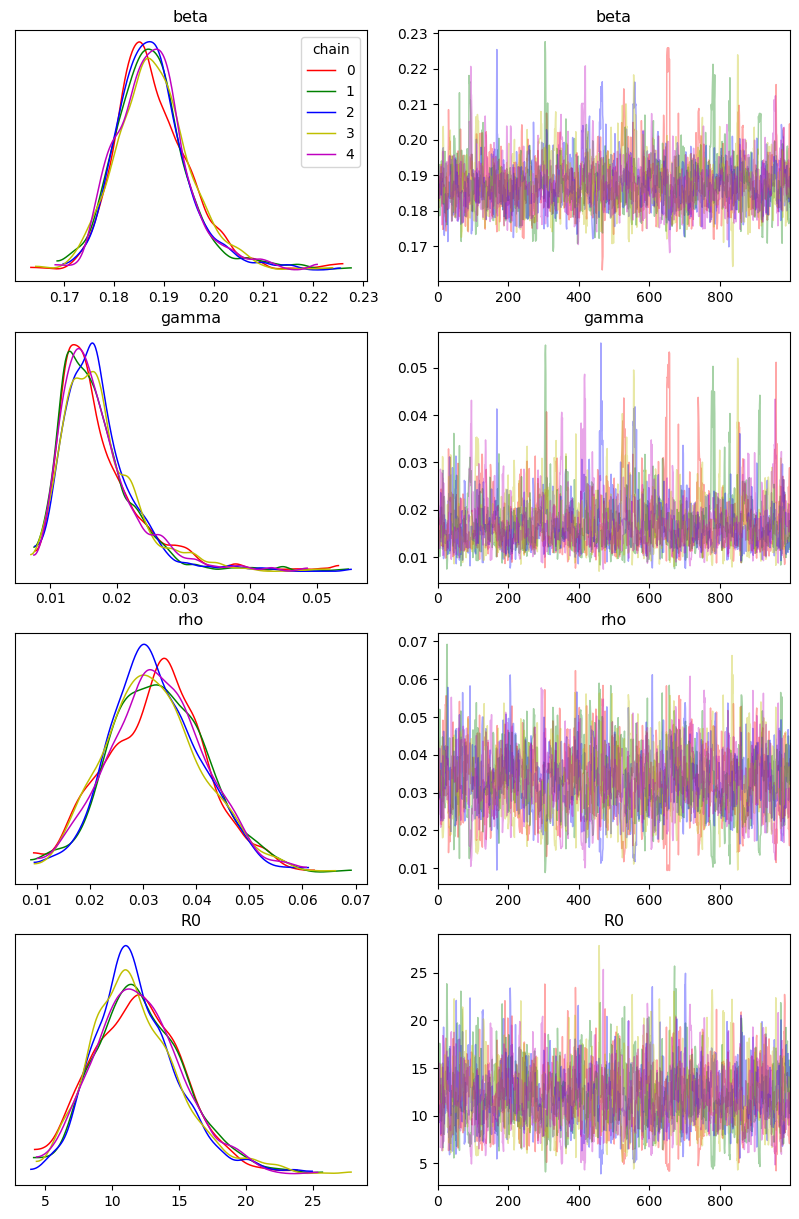

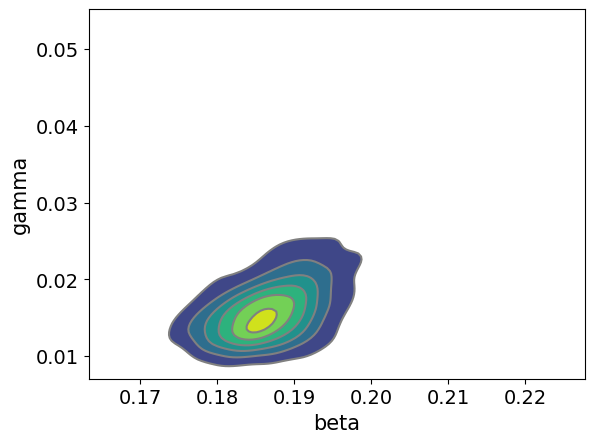

In [111]:
plotMCMC(test)

In [45]:
table = printMCMCTables(test)[['mean','sd','hdi_3%','hdi_97%','r_hat']]
table_graphs = table[["mean","sd"]]
table_graphs_values = table_graphs.loc[["beta","gamma","rho",'i0']]
table 

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,r_hat
i0,8303.27280,92.94803,8136.00000,8483.00000,1.00441
beta,0.18781,0.00700,0.17512,0.20146,1.00158
gamma,0.01704,0.00567,0.00858,0.02709,1.00319
rho,0.03260,0.00880,0.01652,0.04961,1.00207
sigma,71.52540,10.69287,53.29139,92.41863,1.00197
R0,11.98910,3.23381,6.12164,18.01999,1.00361


In [47]:
test2 = runMCMC(dataSets[1],quarantine_one_population[1],'2020-03-30','2020-04-20',30,beta[0],gamma[2],rho[1])

2020-03-30
2020-04-20
[2667 3043 3457 3851 4096 4277 4569 4906 5242 5569 5776 5978 6146 6309
 6527 6756 6945 7118 7240 7358 7504]
[30. 31. 32. 33. 34. 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.
 48. 49. 50.]


Multiprocess sampling (5 chains in 16 jobs)
CompoundStep
>NUTS: [sigma, rho, gamma, beta]
>Metropolis: [i0]


/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 5 chains for 1_000 tune and 1_000 draw iterations (

In [48]:
table = printMCMCTables(test2)[['mean','sd','hdi_3%','hdi_97%','r_hat']]
table_graphs = table[["mean","sd"]]
table_graphs_values = table_graphs.loc[["beta","gamma","rho",'i0']]
table 

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,r_hat
i0,8303.36640,92.12876,8123.00000,8460.00000,1.00724
beta,0.23074,0.04656,0.15901,0.32201,1.00477
gamma,0.20158,0.04752,0.12525,0.29223,1.00402
rho,0.04435,0.00880,0.02725,0.06031,1.00514
sigma,340.85959,54.64762,246.72930,444.76278,1.00305
R0,1.15335,0.04315,1.07439,1.23057,1.00258


In [ ]:
# file names, dates and and offsets for second quarantine
quarantine_two_offsets = []
quarantine_two_dates = []
quarantine_two_population = []


#France
quarantine_two_offsets.append()
quarantine_two_dates.append()
quarantine_two_population.append()

#Germany
quarantine_two_offsets.append()
quarantine_two_dates.append()
quarantine_two_population.append()

#Italy
quarantine_two_offsets.append()
quarantine_two_dates.append()
quarantine_two_population.append()

#Spain
quarantine_two_offsets.append()
quarantine_two_dates.append()
quarantine_two_population.append()

#UK
quarantine_two_offsets.append()
quarantine_two_dates.append()
quarantine_two_population.append()

## Running Analysis

In [29]:
# Begin loop to run all the analysis on the first quarantine
quarantine_one_results = []
count = 0
for index, dataframe in enumerate(dataSets):
    run = True
    while run:
        try:
            quarantine_one_results.append(runMCMC(dataframe,quarantine_one_population[index],quarantine_one_dates[index][0][0],quarantine_one_dates[index][0][1],0,
                                        beta[count], gamma[count], rho[count]))
        except:
            if (count < 6):
                count = count + 1 
            else:
                run = False
                next

2020-03-17
2020-03-17
2020-03-17
2020-03-17
2020-03-17
2020-03-17
2020-03-17
2020-03-02
2020-03-17
2020-03-17
2020-03-17


In [22]:
quarantine_one_results

[]

## Plotting Results

In [ ]:
# Plotting all results of the first set of quarantines
for result in quarantine_one_results:
    plot = pm.plot_trace(result, var_names=('i0','beta','gamma','rho','sigma'),compact=True, legend=True, chain_prop=("ls", "-"))
    
# Plotting all results of the second set of quarantines
for result in quarantine_two_results:
    plot = pm.plot_trace(result, var_names=('i0','beta','gamma','rho','sigma'),compact=True, legend=True, chain_prop=("ls", "-"))

## Data Visualization

In [18]:
import fiona
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

shapefile = "/Users/zenodeangeli/Desktop/IndividualProject/data/ne_110m_admin_0_countries.shp"
geo_df = gpd.read_file(shapefile)

ModuleNotFoundError: No module named 'fiona'

/Users/zenodeangeli/opt/anaconda3/lib/python3.9/site-packages/geopandas/plotting.py:641: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


(30.0, 70.0)

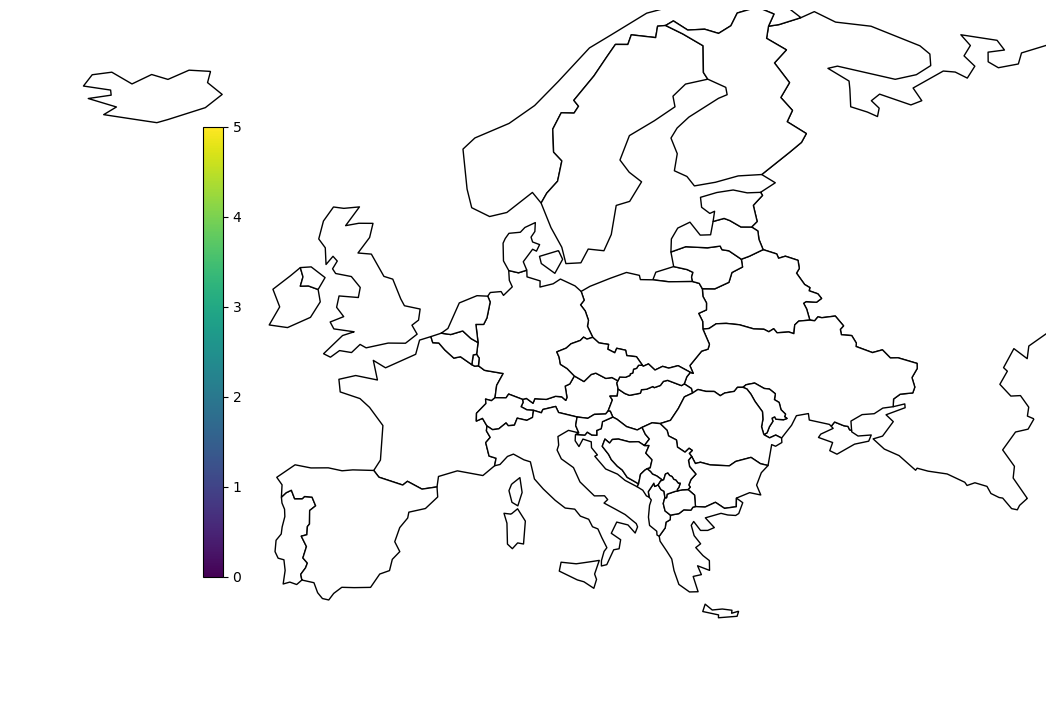

In [58]:
# General Information
country_list = ["Italy", "United Kindgom", "Spain", "Switzerland", "France", "Germany"]
vmin = 0
vmax = 5
col = "Example"
fig, ax = plt.subplots(1, figsize=(20, 9))
ax.axis('off')
africa_map_df = geo_df[geo_df['NAME'].isin(country_list)]

# Plotting the desired continent
geo_df[(geo_df["CONTINENT"] == "Europe")].plot(column=col, ax=ax, color='white', edgecolor='black')

# Adding Cmap to 
cmap = 'viridis'
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=cmap)
cbaxes = fig.add_axes([0.35, 0.25, 0.01, 0.5])
cbar = fig.colorbar(sm, cax=cbaxes)

# Setting Axis limits
ax.set_xlim(-30, 50)
ax.set_ylim(30, 70)